In [2]:
import pandas as pd

from qiime2 import Artifact

import seaborn as sns

import skbio
from skbio.stats.distance import MissingIDError
from skbio import DistanceMatrix

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import csv

import qiime2 as q2

In [4]:
#Load distance matrix
original_dm = Artifact.load('core-metrics-986/unweighted_unifrac_distance_matrix.qza').view(DistanceMatrix)

In [5]:
#load metadata
md = q2.Metadata.load('filtered-metadata.qza').to_dataframe()
md.loc[(md.sample_storage_temp_treatment == '20C') & (md.sample_preservation_method == 'no_preservative'), 'sample_storage_temp_treatment'] = '20C no preservative'

In [6]:
#sync metadata to distance matrix

#remove samples in distance matrix that are not in metadata
original_dm = original_dm.filter(set(md.index) & set(original_dm.ids))

#remove samples in metadata that are not in distance matrix
md = md.loc[list(original_dm.ids)]

In [7]:
class MyDM(skbio.DistanceMatrix):
    def _stable_order(self, ids):

        id_order = sorted(self._id_index[i] for i in ids)
        return np.array(id_order, dtype=int)
    
    def between(self, from_, to_, allow_overlap=False):

        from_ = set(from_)
        to_ = set(to_)

        all_ids = from_ | to_
        not_present = all_ids - set(self._id_index)
        if not_present:
            raise MissingIDError("At least one ID (e.g., '%s') was not "
                                 "found." % not_present.pop())

        overlapping = from_ & to_
        if not allow_overlap and overlapping:
            raise KeyError("At least one ID overlaps in from_ and to_ "
                           "(e.g., '%s'). This constraint can removed with "
                           "allow_overlap=True." % overlapping.pop())

        return self._subset_to_dataframe(from_, to_)
    
    def _subset_to_dataframe(self, i_ids, j_ids):

        i_indices = self._stable_order(i_ids)
        j_indices = self._stable_order(j_ids)

        j_length = len(j_indices)
        j_labels = tuple([self.ids[j] for j in j_indices])

        i = []
        j = []

        values = [np.array([])]
        for i_idx in i_indices:
            i.extend([self.ids[i_idx]] * j_length)
            j.extend(j_labels)

            subset = self._data[i_idx, j_indices]
            values.append(subset)

        i = pd.Series(i, name='i')
        j = pd.Series(j, name='j')
        values = pd.Series(np.hstack(values), name='value')

        return pd.concat([i, j, values], axis=1)

In [8]:
def gather_between_distances(a_dm, a_md, fresh_baseline):
    pleasant_dm = MyDM(a_dm)

    tidy_data = []
    
    categories = ['sample_preservation_method', 'sample_storage_temp_treatment']
    
    baseline_ids = {}
    for hid, grp in md.groupby('host_subject_id'):
        only_fresh = grp[grp['sample_storage_temp_treatment'] == '20C no preservative']
        baseline_ids[hid] = only_fresh.index
        
    for (pres, temp, hid), grp in a_md.groupby(categories + ['host_subject_id']):   
        if hid in baseline_ids:
            base_ids = baseline_ids[hid]
            distances = pleasant_dm.between(base_ids, grp.index, allow_overlap=True)

            distances['sample_preservation_method'] = pres
            distances['sample_storage_temp_treatment'] = temp
            distances['host_subject_id'] = hid
            distances['groupby'] = 'Distance to no preservative'

            tidy_data.append(distances)

    tidy_data = pd.concat(tidy_data)
    
    return tidy_data[tidy_data['i'] != tidy_data['j']]

In [9]:
categories = ['sample_preservation_method', 'sample_storage_temp_treatment']

host_baseline = []

for hid, grp in md.groupby('host_subject_id'):
    for index, row in grp[categories].iterrows():
        if (row == ['no_preservative', '20C no preservative']).all():
            host_baseline.append(index)
            
md_list = []

for i in host_baseline:
    md2 = md[md.index==i]
    md_list.append(md2)
md_df = pd.concat(md_list)

between_distances3 = gather_between_distances(original_dm, md_df, False)

between_distances3.loc[:,"value"].median()

0.4123186804274251

In [10]:
subjects = md['host_subject_id'].unique()
subjects

array(['C', 'B', 'H', 'F', 'E', 'A', 'I', 'J', 'D', 'G'], dtype=object)

In [11]:
subjects = md['host_subject_id'].unique()
already_proc = []
pleasant_dm = MyDM(original_dm)
pairs = []
for s in subjects:
    pairs.append(
        pleasant_dm.between(
            md.loc[md['host_subject_id'] == s].index,
            md.loc[~(md['host_subject_id'] == s) & ~(md['host_subject_id'].isin(already_proc))].index))
    already_proc.append(s)
pd.concat(pairs).loc[:, 'value'].median()

0.7186874586143448

In [21]:
between_distances3

,i,j,value,sample_preservation_method,sample_storage_temp_treatment,host_subject_id,groupby
1,14383.A.none.20C.urine.2,14383.A.none.20C.urine.3,0.337552,no_preservative,20C no preservative,A,Distance to no preservative
2,14383.A.none.20C.urine.2,14383.A.none.20C.urine.1,0.514025,no_preservative,20C no preservative,A,Distance to no preservative
3,14383.A.none.20C.urine.3,14383.A.none.20C.urine.2,0.337552,no_preservative,20C no preservative,A,Distance to no preservative
5,14383.A.none.20C.urine.3,14383.A.none.20C.urine.1,0.403671,no_preservative,20C no preservative,A,Distance to no preservative
6,14383.A.none.20C.urine.1,14383.A.none.20C.urine.2,0.514025,no_preservative,20C no preservative,A,Distance to no preservative
7,14383.A.none.20C.urine.1,14383.A.none.20C.urine.3,0.403671,no_preservative,20C no preservative,A,Distance to no preservative
1,14383.B.none.20C.urine.3,14383.B.none.20C.urine.2,0.443701,no_preservative,20C no preservative,B,Distance to no preservative
2,14383.B.none.20C.urine.3,14383.B.none.20C.urine.1,0.060441,no_preservative,20C no preservative,B,Distance to no preservative
3,14383.B.none.20C.urine.2,14383.B.none.20C.urine.3,0.443701,no_preservative,20C no preservative,B,Distance to no preservative
5,14383.B.none.20C.urine.2,14383.B.none.20C.urine.1,0.466108,no_preservative,20C no preservative,B,Distance to no preservative


In [12]:
md.sample_storage_temp_treatment.unique()

array(['20C no preservative', 'amb', '4C', 'freezethaw', '20C', 'heat'],
      dtype=object)

In [13]:
temps = md.sample_storage_temp_treatment.unique()
pairs = []
for s in subjects:
    for t in temps:
        pairs.append(
            pleasant_dm.between(
                md.loc[(md['host_subject_id'] == s) & (md['sample_storage_temp_treatment'] == t)].index,
                md.loc[(md['host_subject_id'] == s) & (md['sample_storage_temp_treatment'] == t)].index,
                allow_overlap=True)
        )
p = pd.concat(pairs)
p.loc[p['value'] != 0, 'value'].drop_duplicates().median()

0.4226349969628046

In [14]:
def fancy_plotting(df):
    g = sns.catplot(data=df, x='host_subject_id', y='value', hue='sample_storage_temp_treatment', col='groupby',
                    kind='box', col_wrap=3,)
                    #palette=sns.color_palette("RdBu_r", 7)
#                     order=['1week', '4weeks', '8weeks'])
    
    g.set_axis_labels("Subject", "Unweighted Unifrac Distance")
#     g.set_xticklabels(["1 week", "4 weeks", "8 weeks"])
    g.set_titles("{col_name}")
    g._legend.set_title("Temperature Treatment")
    
#     new_labels = ['−20C', '−20C after one week','4C','Ambient','Freeze-thaw','Heat']
#     for t, l in zip(g._legend.texts, new_labels):
#         t.set_text(l)
    
    for ax in g.axes.flat:
        ax.set_title(ax.get_title(), fontsize='xx-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
#         ax.axhline(0.7, ls='-', color='0.1', linewidth=2) #inter-species
        ax.axhline(0.697, ls='-', color='0.3', linewidth=2) #inter-human
#         ax.axhline(0.5, ls='-.', color='0.5', linewidth=2) #inter-dog
        
        ax.axhline(0.423, ls='--', color='0.5', linewidth=2) #inter-replicate
        
    return g

In [20]:
def fancy_plotting_t(df):
    g = sns.catplot(data=df, x='sample_storage_temp_treatment', y='value', hue='sample_storage_temp_treatment', col='groupby',
                    kind='box', col_wrap=3,)
                    #palette=sns.color_palette("RdBu_r", 7)
#                     order=['1week', '4weeks', '8weeks'])
    
    g.set_axis_labels("Temperature", "Unweighted Unifrac Distance")
#     g.set_xticklabels(["1 week", "4 weeks", "8 weeks"])
    g.set_titles("{col_name}")
#     g._legend.set_title("Temperature Treatment")
    
#     new_labels = ['−20C', '−20C after one week','4C','Ambient','Freeze-thaw','Heat']
#     for t, l in zip(g._legend.texts, new_labels):
#         t.set_text(l)
    
    for ax in g.axes.flat:
        ax.set_title(ax.get_title(), fontsize='xx-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
#         ax.axhline(0.7, ls='-', color='0.1', linewidth=2) #inter-species
        ax.axhline(0.697, ls='-', color='0.3', linewidth=2) #inter-human
#         ax.axhline(0.5, ls='-.', color='0.5', linewidth=2) #inter-dog
        
        ax.axhline(0.443, ls='--', color='0.5', linewidth=2) #inter-replicate
        ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
        
    return g

In [19]:
between_distances1 = gather_between_distances(original_dm, md, False)
between_distances1
# between_distances1.loc[:,"value"].median()

,i,j,value,sample_preservation_method,sample_storage_temp_treatment,host_subject_id,groupby
0,14383.A.none.20C.urine.2,14383.A.AssayAssure.20C.urine.2,0.662565,assay_assure,20C,A,Distance to no preservative
1,14383.A.none.20C.urine.2,14383.A.AssayAssure.20C.urine.3,0.468607,assay_assure,20C,A,Distance to no preservative
2,14383.A.none.20C.urine.2,14383.A.AssayAssure.20C.urine.1,0.613609,assay_assure,20C,A,Distance to no preservative
3,14383.A.none.20C.urine.3,14383.A.AssayAssure.20C.urine.2,0.526941,assay_assure,20C,A,Distance to no preservative
4,14383.A.none.20C.urine.3,14383.A.AssayAssure.20C.urine.3,0.389153,assay_assure,20C,A,Distance to no preservative
...,...,...,...,...,...,...,...
2,14383.J.none.20C.urine.1,14383.J.none.20C.urine.3,0.617305,no_preservative,20C no preservative,J,Distance to no preservative
3,14383.J.none.20C.urine.2,14383.J.none.20C.urine.1,0.644748,no_preservative,20C no preservative,J,Distance to no preservative
5,14383.J.none.20C.urine.2,14383.J.none.20C.urine.3,0.655703,no_preservative,20C no preservative,J,Distance to no preservative
6,14383.J.none.20C.urine.3,14383.J.none.20C.urine.1,0.617305,no_preservative,20C no preservative,J,Distance to no preservative


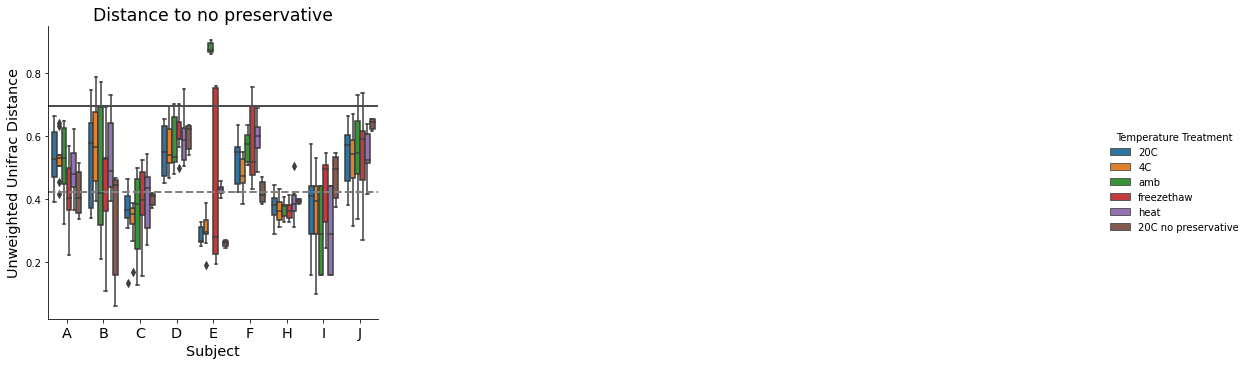

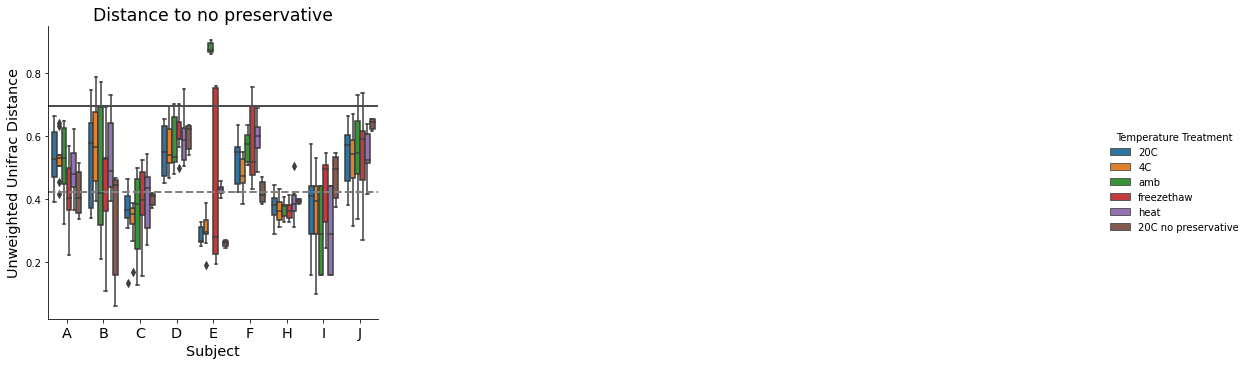

In [17]:
fancy_plotting(between_distances1).savefig("unweighted-temp-bl.png")
fancy_plotting(between_distances1).savefig('UnUF-distance-figure-temp-amb-bl.svg', format='svg', dpi=1200)

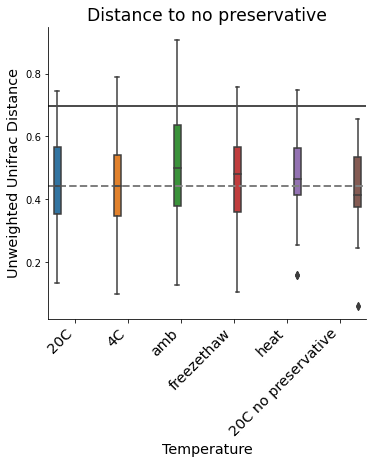

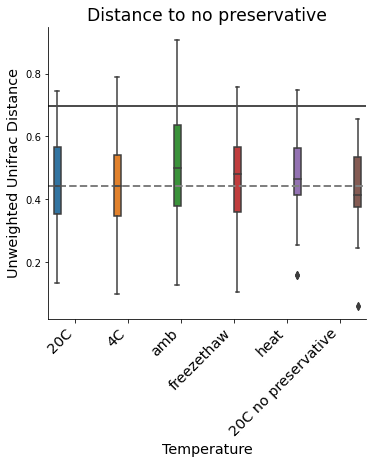

In [18]:
fancy_plotting_t(between_distances1).savefig("unweighted-temp-bl-treat.png")
fancy_plotting_t(between_distances1).savefig('UnUF-distance-figure-temp-amb-bl-treat.svg', format='svg', dpi=1200)

In [39]:
# def fancy_plotting2(df):
#     g = sns.catplot(data=df, x='duration_of_storage', y='value', 
#                     hue='sample_storage_temp_treatment_week_added', col='sample_preservation_method',
#                     kind='box', col_wrap=3,
#                     #palette=sns.color_palette("RdBu_r", 7)
#                     order=['fresh','1week', '4weeks', '8weeks'])
    
#     g.set_axis_labels("Duration of Storage", "Unweighted Unifrac Distance")
#     g.set_xticklabels(["Fresh", "1 week", "4 weeks", "8 weeks"])
#     g.set_titles("{col_name}")
#     g._legend.set_title("Temperature Treatment")
    
#     new_labels = ['−20C', '−20C after one week','4C','Ambient','Freeze-thaw','Heat']
#     for t, l in zip(g._legend.texts, new_labels):
#         t.set_text(l)
    
#     for ax in g.axes.flat:
#         ax.set_title(ax.get_title(), fontsize='xx-large')
#         ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
#         ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
#         ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
#         ax.axhline(0.7, ls='-', color='0.1', linewidth=2) #inter-species
#         ax.axhline(0.55, ls='-', color='0.3', linewidth=2) #inter-human
#         ax.axhline(0.5, ls='-', color='0.5', linewidth=2) #inter-dog
        
#         ax.axhline(0.28, ls='-', color='0.5', linewidth=2) #inter-replicate
        
#     return g

In [18]:
# between_distances2 = gather_between_distances(original_dm, md, False)

In [19]:
# fancy_plotting2(between_distances2).savefig("unweighted-none-fresh-amb-bl.png")
# fancy_plotting2(between_distances2).savefig('UnUF-distance-figure-none-fresh-amb-bl.svg', format='svg', dpi=1200)